In [1]:
# ==========================================
# 📊 Food Delivery Data Analysis Project
# ==========================================

import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style for better visuals
plt.style.use('ggplot')

print("🚀 Starting Analysis Pipeline...")

🚀 Starting Analysis Pipeline...


In [2]:
# 1. Load Orders (CSV)
try:
    df_orders = pd.read_csv('orders.csv')
    print(f"✅ Loaded Orders: {df_orders.shape[0]} records")
except FileNotFoundError:
    print("❌ Error: orders.csv not found.")

# 2. Load Users (JSON)
try:
    # Try standard JSON first, then lines=True if needed
    try:
        df_users = pd.read_json('users.json')
    except ValueError:
        df_users = pd.read_json('users.json', lines=True)
    print(f"✅ Loaded Users: {df_users.shape[0]} records")
except FileNotFoundError:
    print("❌ Error: users.json not found.")

# 3. Load Restaurants (SQL)
try:
    # Create in-memory DB
    conn = sqlite3.connect(':memory:')
    with open('restaurants.sql', 'r') as f:
        sql_script = f.read()
        conn.executescript(sql_script)
    
    # Query data
    df_restaurants = pd.read_sql("SELECT * FROM restaurants", conn)
    print(f"✅ Loaded Restaurants: {df_restaurants.shape[0]} records")
except FileNotFoundError:
    print("❌ Error: restaurants.sql not found.")

✅ Loaded Orders: 10000 records
✅ Loaded Users: 3000 records
✅ Loaded Restaurants: 500 records


In [3]:
# ---------------------------------------------------------
# SECTION 2: DATA MERGING
# ---------------------------------------------------------

# Merge Orders + Users (Left Join)
df_merged = pd.merge(df_orders, df_users, on='user_id', how='left')

# Merge Result + Restaurants (Left Join)
df_final = pd.merge(df_merged, df_restaurants, on='restaurant_id', how='left')

# Convert Dates
# Handling potential mixed formats, assuming day-first based on your data (e.g., 18-02-2023)
df_final['order_date'] = pd.to_datetime(df_final['order_date'], dayfirst=True)

# Save the Source of Truth
df_final.to_csv('final_food_delivery_dataset.csv', index=False)
print(f"💾 Dataset Saved: final_food_delivery_dataset.csv ({df_final.shape[0]} rows)")

💾 Dataset Saved: final_food_delivery_dataset.csv (10000 rows)


In [4]:
# ---------------------------------------------------------
# SECTION 3: KEY PERFORMANCE INDICATORS (KPIs)
# ---------------------------------------------------------

print("\n--- 🔢 NUMERIC ANSWERS ---")

# 1. Total Orders by Gold Members
gold_orders = df_final[df_final['membership'] == 'Gold'].shape[0]
print(f"1. Total Gold Orders: {gold_orders}")

# 2. Total Revenue from Hyderabad
hyd_revenue = df_final[df_final['city'] == 'Hyderabad']['total_amount'].sum()
print(f"2. Revenue from Hyderabad: {round(hyd_revenue)}")

# 3. Distinct Users
distinct_users = df_final['user_id'].nunique()
print(f"3. Distinct Users: {distinct_users}")

# 4. Avg Order Value (Gold)
avg_gold = df_final[df_final['membership'] == 'Gold']['total_amount'].mean()
print(f"4. Avg Order Value (Gold): {round(avg_gold, 2)}")

# 5. Orders with Rating >= 4.5
high_rated_orders = df_final[df_final['rating'] >= 4.5].shape[0]
print(f"5. Orders with Rating >= 4.5: {high_rated_orders}")


--- 🔢 NUMERIC ANSWERS ---
1. Total Gold Orders: 4987
2. Revenue from Hyderabad: 1889367
3. Distinct Users: 2883
4. Avg Order Value (Gold): 797.15
5. Orders with Rating >= 4.5: 3374


In [5]:
# ---------------------------------------------------------
# SECTION 4: ADVANCED ANALYSIS (Hackathon Questions)
# ---------------------------------------------------------
print("\n--- 🧠 HACKATHON INSIGHTS ---")

# Q1: City with highest Gold revenue
gold_city_rev = df_final[df_final['membership'] == 'Gold'].groupby('city')['total_amount'].sum().idxmax()
print(f"Q1. Top Gold Revenue City: {gold_city_rev}")

# Q2: Cuisine with highest Avg Order Value
top_avg_cuisine = df_final.groupby('cuisine')['total_amount'].mean().idxmax()
print(f"Q2. Highest Avg Value Cuisine: {top_avg_cuisine}")

# Q3: Users with > 1000 Total Spend
user_spend = df_final.groupby('user_id')['total_amount'].sum()
big_spenders = (user_spend > 1000).sum()
print(f"Q3. Users spending > 1000: {big_spenders}")

# Q4: Revenue by Rating Range
# Creating bins: 3.0-3.5, 3.6-4.0, 4.1-4.5, 4.6-5.0
bins = [2.9, 3.5, 4.0, 4.5, 5.0]
labels = ['3.0-3.5', '3.6-4.0', '4.1-4.5', '4.6-5.0']
df_final['rating_range'] = pd.cut(df_final['rating'], bins=bins, labels=labels)
top_rating_range = df_final.groupby('rating_range', observed=False)['total_amount'].sum().idxmax()
print(f"Q4. Top Revenue Rating Range: {top_rating_range}")

# Q5: Top City for Avg Order Value (Gold Members)
top_gold_avg_city = df_final[df_final['membership'] == 'Gold'].groupby('city')['total_amount'].mean().idxmax()
print(f"Q5. Top Avg Value City (Gold): {top_gold_avg_city}")

# Q6: Cuisine: Low Restaurants, High Revenue
# (Analyzing count of unique restaurants vs total revenue)
cuisine_stats = df_final.groupby('cuisine').agg({'restaurant_id': 'nunique', 'total_amount': 'sum'})
low_rest_cuisine = cuisine_stats.sort_values('restaurant_id').index[0]
print(f"Q6. Cuisine with fewest restaurants: {low_rest_cuisine}")

# Q7: Percentage of Gold Orders
pct_gold = (gold_orders / len(df_final)) * 100
print(f"Q7. Gold Order %: {round(pct_gold)}%")

# Q8: High Avg Value Restaurant with < 20 orders
# Note: Using restaurant_name from the Orders file (often restaurant_name_x)
# If merge created _x and _y, check which one is valid. Usually _y comes from the clean SQL master.
rest_col = 'restaurant_name_y' if 'restaurant_name_y' in df_final.columns else 'restaurant_name'
rest_stats = df_final.groupby(rest_col).agg({'total_amount': 'mean', 'order_id': 'count'})
hidden_gem = rest_stats[rest_stats['order_id'] < 20]['total_amount'].idxmax()
print(f"Q8. Highest Value Niche Restaurant (<20 orders): {hidden_gem}")

# Q9: Highest Revenue Combination
combo = df_final.groupby(['membership', 'cuisine'])['total_amount'].sum().idxmax()
print(f"Q9. Best Revenue Combo: {combo}")

# Q10: Top Revenue Quarter
df_final['quarter'] = df_final['order_date'].dt.quarter
top_q = df_final.groupby('quarter')['total_amount'].sum().idxmax()
print(f"Q10. Best Revenue Quarter: Q{top_q}")


--- 🧠 HACKATHON INSIGHTS ---
Q1. Top Gold Revenue City: Chennai
Q2. Highest Avg Value Cuisine: Mexican
Q3. Users spending > 1000: 2544
Q4. Top Revenue Rating Range: 4.6-5.0
Q5. Top Avg Value City (Gold): Chennai
Q6. Cuisine with fewest restaurants: Chinese
Q7. Gold Order %: 50%
Q8. Highest Value Niche Restaurant (<20 orders): Restaurant_294
Q9. Best Revenue Combo: ('Regular', 'Mexican')
Q10. Best Revenue Quarter: Q3


C:\Users\sathw\AppData\Local\Temp\ipykernel_8220\1606525717.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='membership', y='total_amount', data=df_final, estimator=sum, palette='viridis')


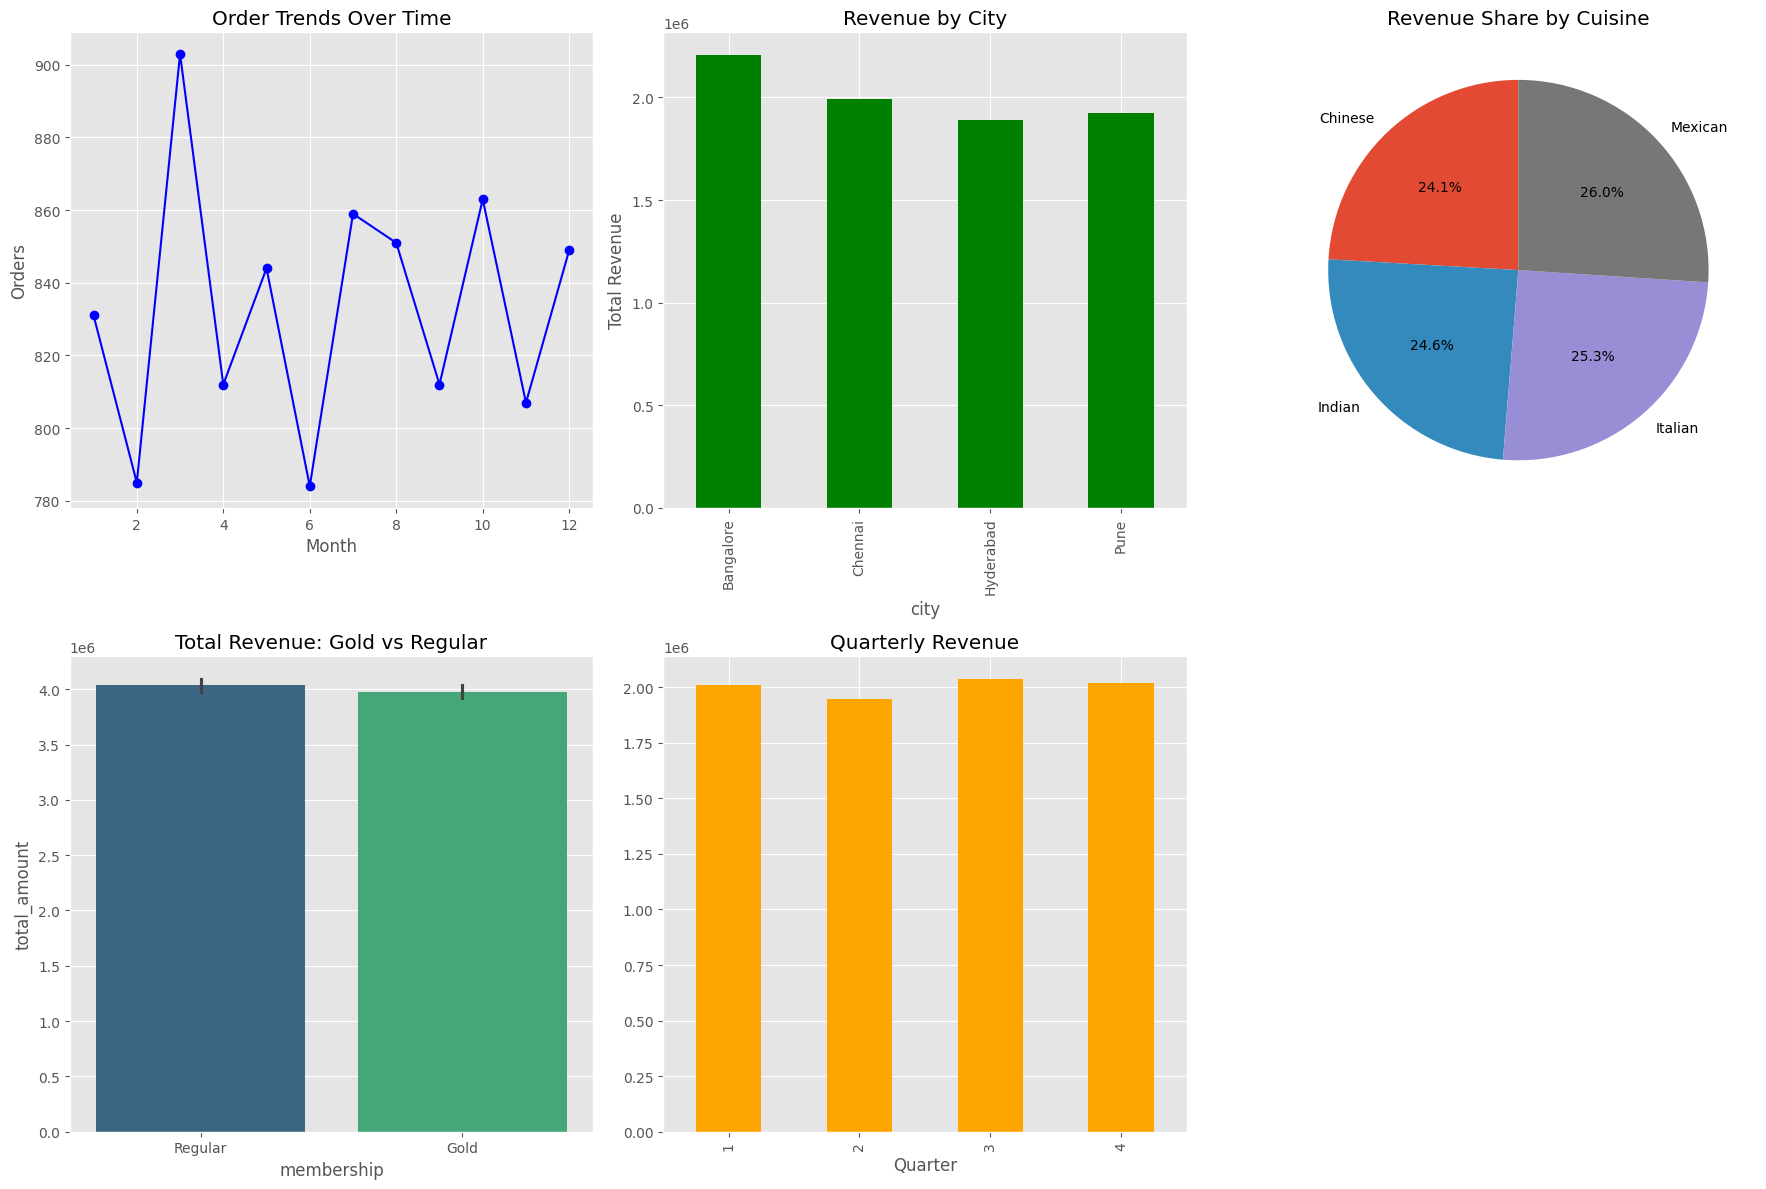


✅ Analysis Complete.


In [6]:
# ---------------------------------------------------------
# SECTION 5: VISUALIZATIONS
# ---------------------------------------------------------

plt.figure(figsize=(18, 12))

# 1. Order Trends (Monthly)
plt.subplot(2, 3, 1)
df_final['month'] = df_final['order_date'].dt.month_name()
# Sort by month number for correct order
monthly_data = df_final.groupby(df_final['order_date'].dt.month)['order_id'].count()
monthly_data.plot(kind='line', marker='o', color='b')
plt.title('Order Trends Over Time')
plt.xlabel('Month')
plt.ylabel('Orders')
plt.grid(True)

# 2. City Performance (Revenue)
plt.subplot(2, 3, 2)
df_final.groupby('city')['total_amount'].sum().plot(kind='bar', color='green')
plt.title('Revenue by City')
plt.ylabel('Total Revenue')

# 3. Cuisine Performance (Revenue)
plt.subplot(2, 3, 3)
df_final.groupby('cuisine')['total_amount'].sum().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Revenue Share by Cuisine')
plt.ylabel('')

# 4. Membership Impact (Gold vs Regular)
plt.subplot(2, 3, 4)
sns.barplot(x='membership', y='total_amount', data=df_final, estimator=sum, palette='viridis')
plt.title('Total Revenue: Gold vs Regular')

# 5. Seasonality (Revenue per Quarter)
plt.subplot(2, 3, 5)
df_final.groupby('quarter')['total_amount'].sum().plot(kind='bar', color='orange')
plt.title('Quarterly Revenue')
plt.xlabel('Quarter')

plt.tight_layout()
plt.show()

print("\n✅ Analysis Complete.")